In [29]:
import matplotlib.pyplot as plt
import csv
import numpy as np

begin, end = 1, 61 # (begin is inclusive, end is exclusive)
time = np.arange(begin, end, 1)

# Class to cleanly save samples
class Sample:
    def __init__(self):
        self.data = {
            'RawEEG': [],
            'Alpha': [],
            'Low Beta': [],
            'High Beta': [],
            'Gamma': [],
            'Theta': [],
            'Delta': [],
            'Meditation': [],
            'Attention': []
        }

    def recordDataPoint(self, RawEEG, Attention, Meditation, Alpha, Delta, Theta, LowBeta, HighBeta, Gamma):
        self.data['RawEEG'].append(float(RawEEG))
        self.data['Attention'].append(float(Attention))
        self.data['Meditation'].append(float(Meditation))
        self.data['Alpha'].append(float(Alpha))
        self.data['Delta'].append(float(Delta))
        self.data['Theta'].append(float(Theta))
        self.data['Low Beta'].append(float(LowBeta))
        self.data['High Beta'].append(float(HighBeta))
        self.data['Gamma'].append(float(Gamma))

    '''
    Record a line of data from the CSV output, which takes form RawEEG, Alpha, Delta, Gamma, Low Beta, High Beta, Theta, Attention, Meditation

    '''
    def recordDataLine(self, line):
        self.recordDataPoint(line[0], line[7], line[8], line[1], line[2], line[6], line[4], line[5], line[3])
    
    def getEEG(self):
        return self.data['RawEEG']
    
    def getAttention(self):
        return self.data["Attention"]
    
    def getMeditation(self):
        return self.data["Meditation"]
    
    def getAlpha(self):
        return self.data["Alpha"]
    
    def getDelta(self):
        return self.data["Delta"]
    
    def getTheta(self):
        return self.data["Theta"]
    
    def getLowBeta(self):
        return self.data["Low Beta"]
    
    def getHighBeta(self):
        return self.data["High Beta"]
    
    def getGamma(self):
        return self.data["Gamma"]

    def get(self, key):
        return self.data[key]

    def getEngagement(self):
        return [20 * (low_beta + high_beta) / (alpha + theta) for low_beta, high_beta, alpha, theta in zip(self.data['Low Beta'], self.data['High Beta'], self.data['Alpha'], self.data['Theta'])]
    
    '''
    Filter out all outliers, as defined by being outside 2*std from the mean, and replace with mean of the samples around them
    '''
    def filter_outliers(self):
        sampleBad = False
        for key in ['RawEEG', 'Alpha', 'Theta', 'Low Beta', 'High Beta', "Gamma", 'Delta']:
            data = self.data[key]
            
            filtered = []
            for i, x in enumerate(data):
                if (key != "RawEEG" and (x > 0.8)):
                    sampleBad = True
                    break
                elif abs(x - np.mean(data)) < 2 * np.std(data):
                    filtered.append(x)
                else:
                    filtered.append(np.mean(data[max(0, i-5):i] + data[i+1:min(len(data), i+5)])) # Mean of the four values in closest time to the outlier, but avoiding index out of bounds
                    # filtered.append(np.median(data))
                    
            self.data[key] = filtered
        return sampleBad

    def scale(self):
        eeg_std_dev = np.std(self.data['RawEEG'])
        self.data['Alpha'] = [x / eeg_std_dev for x in self.data['Alpha']]
        self.data['Delta'] = [x / eeg_std_dev for x in self.data['Delta']]
        self.data['Theta'] = [x / eeg_std_dev for x in self.data['Theta']]
        self.data['Low Beta'] = [x / eeg_std_dev for x in self.data['Low Beta']]
        self.data['High Beta'] = [x / eeg_std_dev for x in self.data['High Beta']]
        self.data['Gamma'] = [x / eeg_std_dev for x in self.data['Gamma']]

In [30]:
num_samples = 8
n_people = 12

data = [[] for _ in range(n_people)]
dataLabels = [[] for _ in range(n_people)]

folder = "classifier_v2/data/all_data/"

def transcribeFileToSample(brainState: str, personNum: int, sampleNum: int):

    sampleData = Sample()
    
    with open(f'{folder}/{brainState}_{personNum}_{sampleNum}.csv') as csvFile:
        reader = csv.reader(csvFile)
        header = next(reader)

        for row in reader:
            sampleData.recordDataPoint(row[0], row[7], row[8], row[1], row[2], row[6], row[4], row[5], row[3])
    
    # sampleBad = sampleData.filter_outliers()
    sampleBad = False

    if (not sampleBad):   
        # sampleData.filter_outliers()
        data[personNum - 1].append(sampleData)
        dataLabels[personNum - 1].append(brainState)

for state in ["active", "meditate", "neutral"]:
    for personNum in range(1, n_people + 1):
        for sampleNum in range(1, num_samples+1):
            transcribeFileToSample(state, personNum, sampleNum)

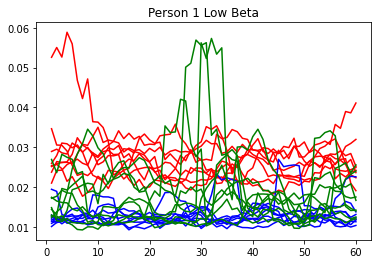

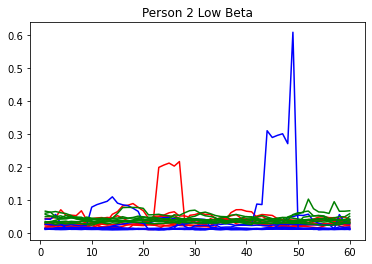

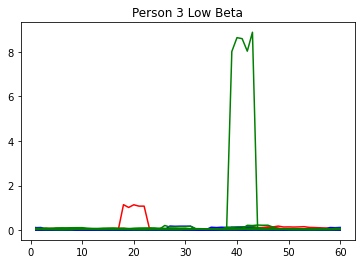

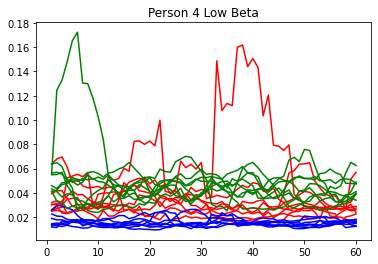

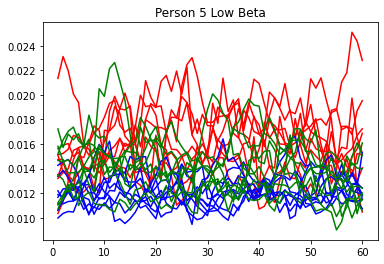

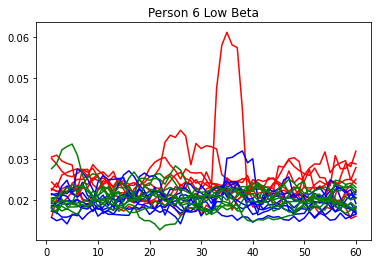

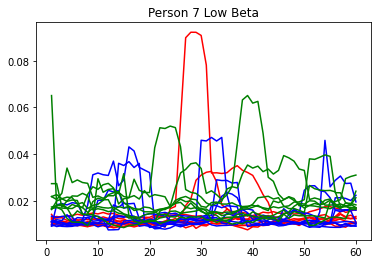

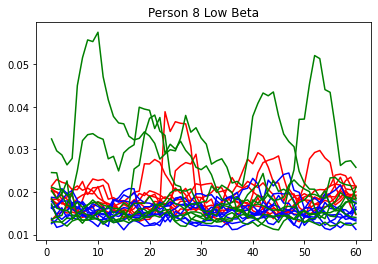

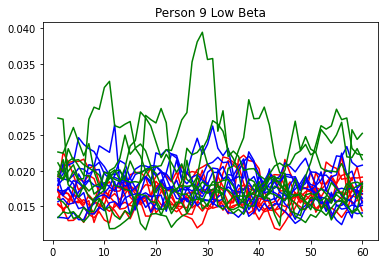

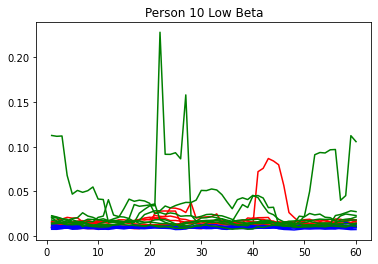

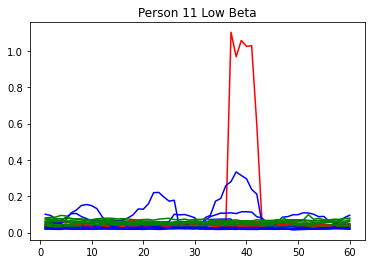

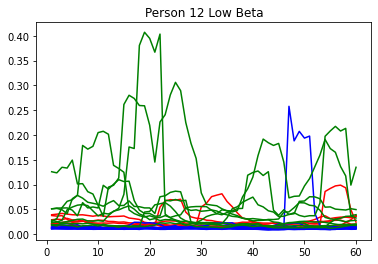

<Figure size 432x288 with 0 Axes>

In [31]:
def plot_feature(feature: str):
    plt.figsize = (10, 10)
    for i in range(n_people):
        # plt.subplot(1, n_people, i + 1)
        plt.title(f"Person {i + 1} {feature}")
        for sample, label in zip(data[i], dataLabels[i]):
            if label == "active":
                plt.plot(time, sample.get(feature), 'r')
            elif label == "neutral":
                plt.plot(time, sample.get(feature), 'g')
            elif label == "meditate":
                plt.plot(time, sample.get(feature), 'b')

        plt.show()
        plt.clf()

plot_feature("Low Beta")

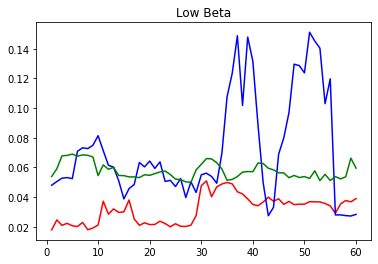

<Figure size 432x288 with 0 Axes>

In [32]:
personNum = "11"
full_data = []

src_folder = f"classifier_v2/data/{personNum}"

def transcribe_full_data(brainState: str):

    sample_data = Sample()
    
    with open(f'{src_folder}/{brainState}.csv') as csvFile:
        reader = csv.reader(csvFile)

        header = next(reader)
        
        for row in reader:
            sample_data.recordDataLine(row)
            
        for key in sample_data.data:
            sample_data.data[key] = sample_data.data[key][begin:end]

        sampleBad = sample_data.filter_outliers()

        if (not sampleBad):   
            sample_data.filter_outliers()
            full_data.append(sample_data)

for state in ["active", "meditate", "neutral"]:
    transcribe_full_data(state)

def plot_full_data(feature: str):

    #plt.title(f"Person {personNum} {feature}")
    plt.title(f"{feature}")

    for sample, label in zip(full_data, ["active", "meditate", "neutral"]):
        sample_len = len(sample.get(feature))
        time = np.arange(1, sample_len + 1, 1)
        if label == "active":
            plt.plot(time, sample.get(feature), 'r')
        elif label == "neutral":
            plt.plot(time, sample.get(feature), 'g')
        elif label == "meditate":
            plt.plot(time, sample.get(feature), 'b')
    plt.show()
    plt.clf()

plot_full_data("Low Beta")

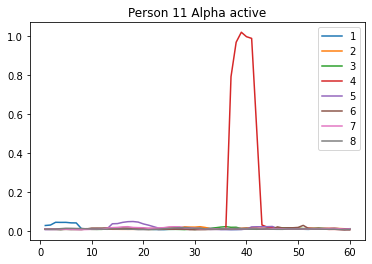

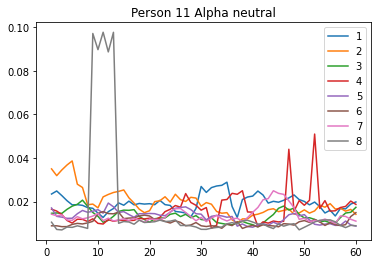

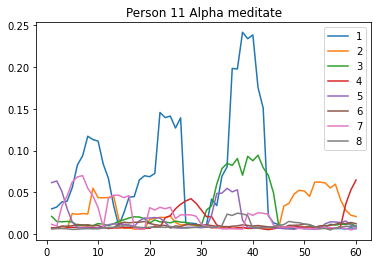

<Figure size 432x288 with 0 Axes>

In [54]:
feature = "Alpha"

def plot_samples(personNum: int, state: str):
    plt.figsize = (10, 10)
    plt.title(f"Person {personNum} {feature} {state}")
    count = 1
    for sample, label in zip(data[personNum - 1], dataLabels[personNum - 1]):
        if label == state:
            plt.plot(time, sample.get(feature), label=count)
            count += 1
    leg = plt.legend(loc='upper right')

    plt.show()
    plt.clf()

personN = 11
for state in ["active", "neutral", "meditate"]:
    plot_samples(personN, state)

# 1 active 5 neutral 2
# 3 active 4 1 neutral 1 meditate 7 5 8 6
# 4 active 2 neutral 7 maybe 1 meditate 1 8
# 6 neutral 2 6
# 7 active 5 neutral 7 6 maybe 4 meditate 8 maybe 143
# 8 active 5 neutral 1 meditate maybe 85
# 10 active 6 8 neutral 4 5 6  
# 11 active 4 neutral 8 maybe 4 meditate 1 3 2 7 5
# 12 active 2 3 8 neutral 3 4 1 5 2 meditate 6